In [1]:
# 利用VGG16 预训练模型 对猫狗图片进行分类识别
# 第一种方法：使用VGG16 对我们的数据进行特征提取 不使用数据增强 并保存为numpy数组

In [2]:
from keras.applications import VGG16

Using TensorFlow backend.


In [5]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [6]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [60]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [9]:
train_dir = "./data/dogs-vs-cats/cats_and_dogs_small/train/"
validation_dir = "./data/dogs-vs-cats/cats_and_dogs_small/validation/"
test_dir = "./data/dogs-vs-cats/cats_and_dogs_small/test/"

In [39]:
def feature_extract(directory, sample_count, batch_size):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(directory, batch_size=20, target_size=(150, 150), class_mode='binary')
    # 申请一个vgg 16卷积基大小的空间
    features = np.zeros((sample_count, 4, 4, 512))
    labels = np.zeros((sample_count))
    i = 0
    batch_size = batch_size
    for batch_data, batch_label in generator:
        features[i*batch_size: (i+1)*batch_size] = conv_base.predict(batch_data)
        labels[i*batch_size: (i+1)*batch_size] = batch_label
        i += 1
        if i*batch_size >= sample_count:
            break
    return features, labels

In [40]:
train_features, train_labels = feature_extract(directory=train_dir, sample_count=2000, batch_size=20)

Found 2000 images belonging to 2 classes.


In [41]:
validation_features, validation_labels = feature_extract(directory=validation_dir, sample_count=1000, batch_size=20)

Found 1000 images belonging to 2 classes.


In [42]:
test_features, test_labels = feature_extract(directory=test_dir, sample_count=1000, batch_size=20)

Found 1000 images belonging to 2 classes.


In [44]:
train_features = train_features.reshape((2000, 4*4*512))
validation_features = validation_features.reshape((1000, 4*4*512))
test_features = test_features.reshape((1000, 4*4*512))

In [46]:
train_features.shape, validation_features.shape, test_features.shape

((2000, 8192), (1000, 8192), (1000, 8192))

In [47]:
# 定义一个Dense层的分类器
from keras import layers
from keras import models
from keras import optimizers

In [48]:
model = models.Sequential()

In [49]:
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))

In [51]:
model.add(layers.Dropout(0.5))

In [52]:
model.add(layers.Dense(1, activation='sigmoid'))

In [53]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [54]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 275us/step - loss: 0.5856 - acc: 0.6715 - val_loss: 0.4451 - val_acc: 0.8360
Epoch 2/30
2000/2000 [==============================] - 0s 146us/step - loss: 0.4177 - acc: 0.8160 - val_loss: 0.3627 - val_acc: 0.8610
Epoch 3/30
2000/2000 [==============================] - 0s 145us/step - loss: 0.3611 - acc: 0.8415 - val_loss: 0.3305 - val_acc: 0.8670
Epoch 4/30
2000/2000 [==============================] - 0s 145us/step - loss: 0.3145 - acc: 0.8725 - val_loss: 0.3064 - val_acc: 0.8710
Epoch 5/30
2000/2000 [==============================] - 0s 145us/step - loss: 0.2888 - acc: 0.8835 - val_loss: 0.2886 - val_acc: 0.8850
Epoch 6/30
2000/2000 [==============================] - 0s 145us/step - loss: 0.2651 - acc: 0.8995 - val_loss: 0.2785 - val_acc: 0.8820
Epoch 7/30
2000/2000 [==============================] - 0s 145us/step - loss: 0.2467 - acc: 0.9095 - val_loss: 0.2711 - val_acc: 0.8940


In [56]:
# 精度和loss观察
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [57]:
val_loss = history.history['val_loss']
loss = history.history['loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

In [58]:
epochs = [i+1 for i in range(30)]

<Figure size 432x288 with 0 Axes>

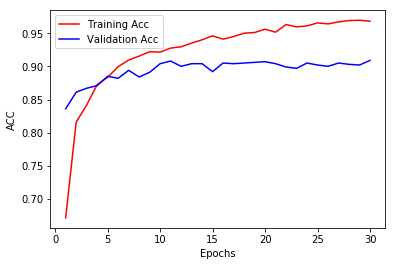

<Figure size 432x288 with 0 Axes>

In [62]:
plt.plot(epochs, acc, color='r', label='Training Acc')
plt.plot(epochs, val_acc, color='b', label='Validation Acc')
plt.xlabel("Epochs")
plt.ylabel("ACC")
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

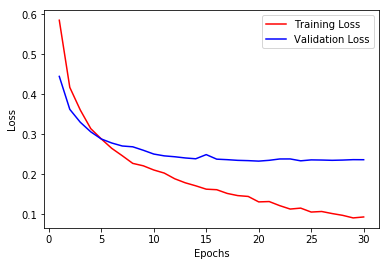

<Figure size 432x288 with 0 Axes>

In [70]:
plt.plot(epochs, loss, color='r', label='Training Loss')
plt.plot(epochs, val_loss, color='b', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()

In [72]:
type(conv_base)

keras.engine.training.Model